*TEMUULEN Bulgan* (2025-4-22)

# IMAGE CLASSIFICATION: TOM AND JERRY

This small-scale project was carried out as an exploratory experiment in the field of computer vision using neural networks. The aim was to gain a practical understanding of how deep learning models can interpret and classify images. For this purpose, a publicly available dataset from Kaggle was utilized, which is distributed under the CC0: Public Domain License. The dataset comprises a total of 5,478 images, categorized into four distinct classes, providing a diverse set of visual inputs suitable for training and evaluating image classification models.

In [1]:
# Load nessesary libraries
import os
import random
import warnings
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Handle warnings
warnings.filterwarnings('ignore')

## Data analysis

In [2]:
# List and print all files in the 'images' folder
folder_path = r'images'
files = os.listdir(folder_path)

for f in files:
    print(f)

jerry
tom
tom_jerry_0
tom_jerry_1


The dataset is stored in the images folder with four subfolders corresponding to the different categories. The images are first loaded and their distribution across categories is analyzed.

In [3]:
# Define subfolder paths for different categories within the main 'images' folder
jerry_dir = os.path.join(folder_path, 'jerry')
tom_dir = os.path.join(folder_path, 'tom')
tom_jerry_0_dir = os.path.join(folder_path, 'tom_jerry_0')
tom_jerry_1_dir = os.path.join(folder_path, 'tom_jerry_1')

# Map category names to their respective folder paths
folders = {'Jerry': jerry_dir,
           'Tom': tom_dir,
           'without Tom and Jerry': tom_jerry_0_dir,
           'with both Tom and Jerry': tom_jerry_1_dir}

The folder paths are defined for each category: Jerry, Tom, without Tom and Jerry, and with both Tom and Jerry.

In [4]:
# Initialize lists to store category names and their image counts
labels, counts = [], []

# Iterate over each category folder to count images and check image size distribution
for name, path in folders.items():
    count = len(os.listdir(path)) # Count total images in the folder
    labels.append(name)
    counts.append(count)
    
    sizes = []
    for filename in os.listdir(path):
        image_path = os.path.join(path, filename)
        try:
            # Open image and record its size (width, height)
            with Image.open(image_path) as img:
                sizes.append(img.size)
        except:
            print(f"Couldn't open: {filename}")

    # Count how many images share the same size in this folder
    size_counts = Counter(sizes)
    
    # Print the distribution of image sizes for this folder
    print(f"\nImage size distribution in '{name}' folder:")
    for size, count in size_counts.items():
        print(f"  Size {size}: {count} image(s)")


Image size distribution in 'Jerry' folder:
  Size (1280, 720): 213 image(s)
  Size (854, 480): 1027 image(s)

Image size distribution in 'Tom' folder:
  Size (1280, 720): 451 image(s)
  Size (854, 480): 1479 image(s)

Image size distribution in 'without Tom and Jerry' folder:
  Size (1280, 720): 401 image(s)
  Size (854, 480): 1127 image(s)

Image size distribution in 'with both Tom and Jerry' folder:
  Size (1280, 720): 218 image(s)
  Size (854, 480): 562 image(s)


The number of images in each category is counted and the distribution of image sizes is analyzed. This step ensures consistency in image dimensions.

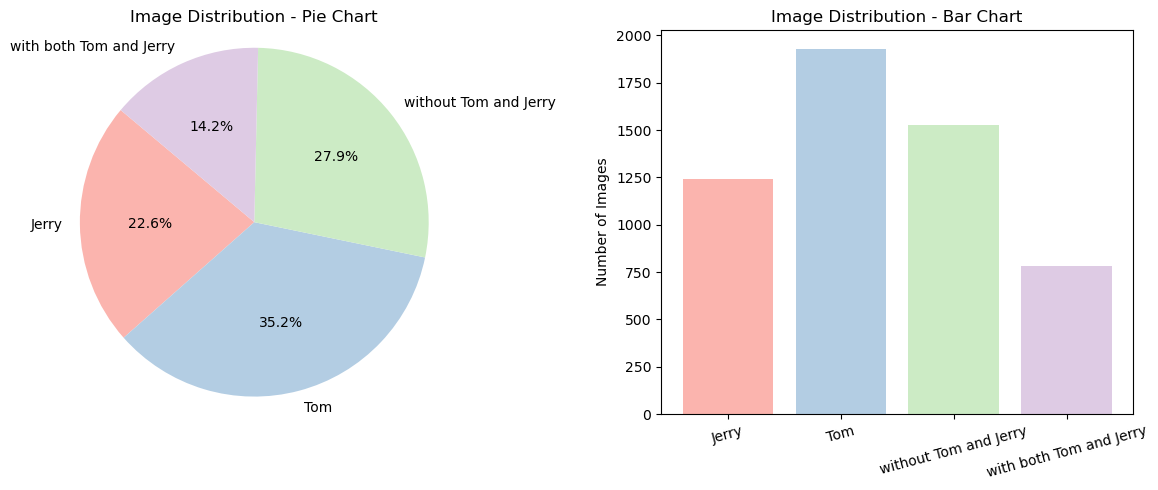

In [5]:
# Visualizing the distribution of images across categories using a pie chart and a bar chart
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Pastel1.colors)
plt.title('Image Distribution - Pie Chart')
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.bar(labels, counts, color=plt.cm.Pastel1.colors)
plt.title('Image Distribution - Bar Chart')
plt.ylabel('Number of Images')
plt.xticks(rotation=15)

plt.tight_layout()
plt.show()

A pie chart and a bar chart are used to visualize the distribution of images across categories. These visualizations help understand the dataset's balance.

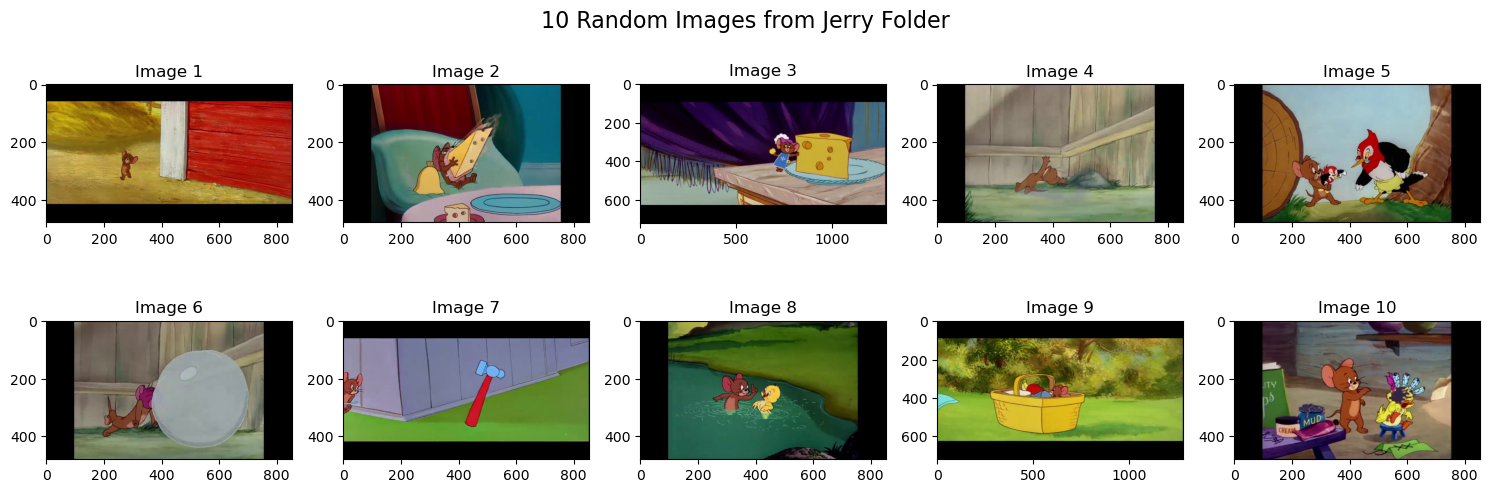

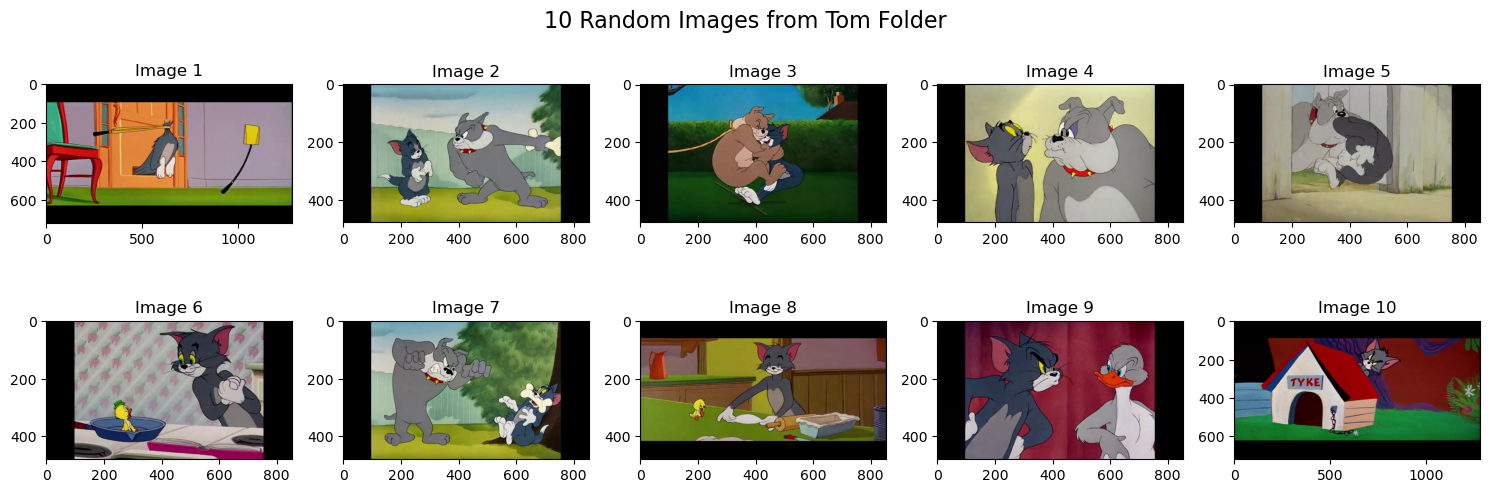

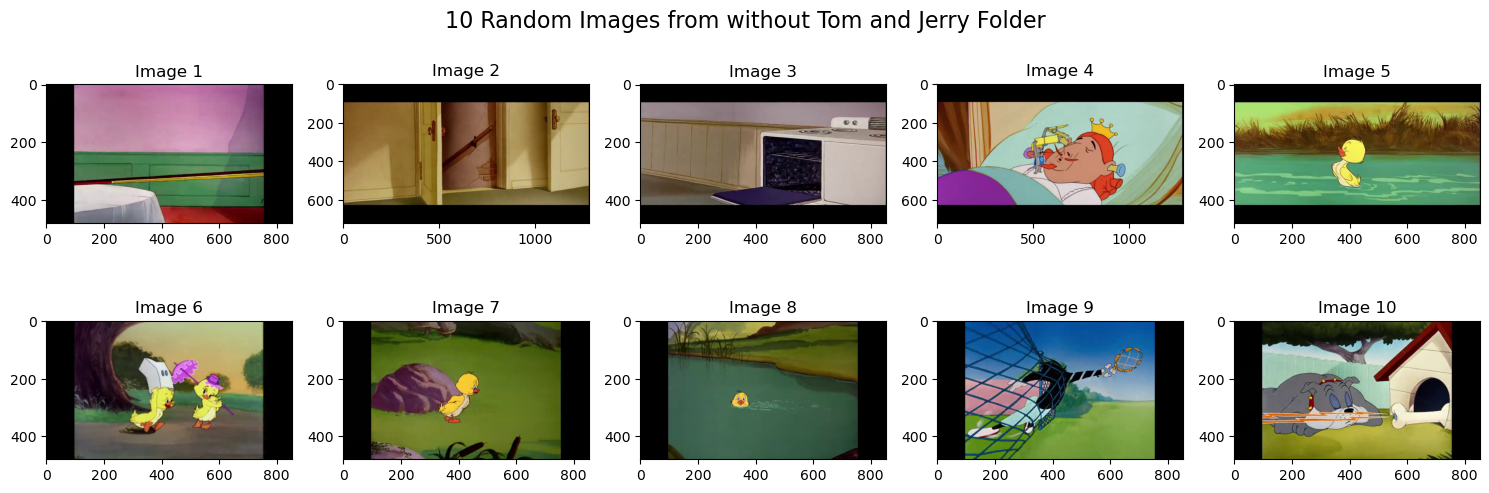

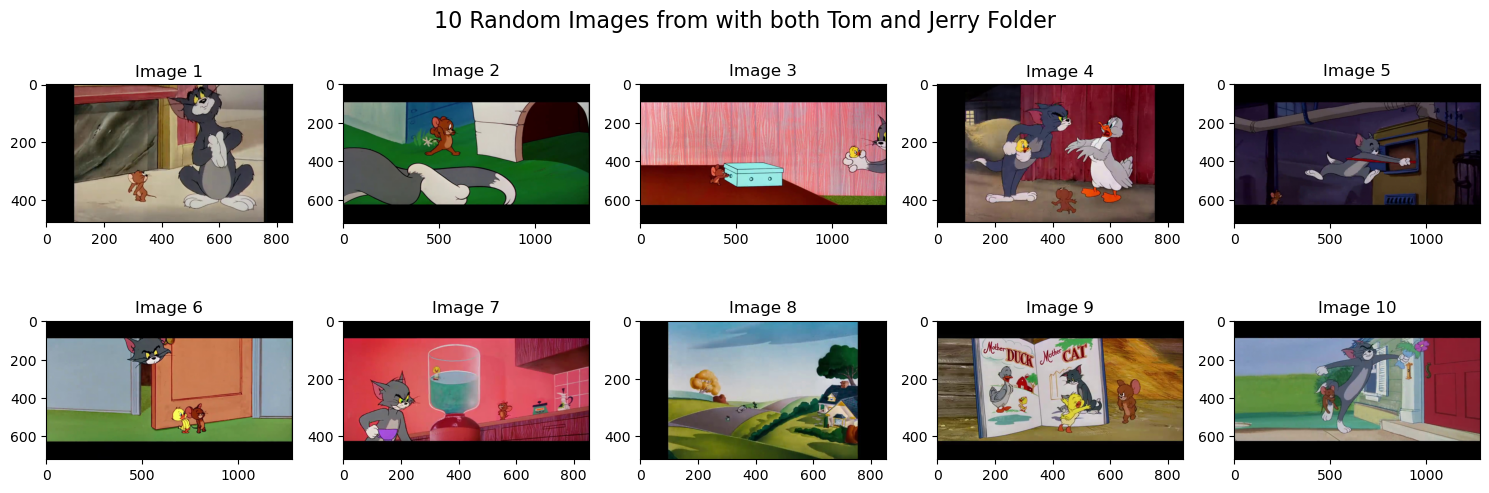

In [6]:
# Displaying 10 randomly selected images from each category folder to visually inspect the dataset
for name, path in folders.items():
    image_files = os.listdir(path)
    random_images = random.sample(image_files, 10)

    plt.figure(figsize=(15, 10))
    for i, img_name in enumerate(random_images):
        img_path = os.path.join(path, img_name)
        image = Image.open(img_path)

        plt.subplot(4, 5, i + 1)
        plt.imshow(image)
        plt.title(f'Image {i + 1}')
        plt.axis('on')

    plt.suptitle(f'10 Random Images from {name} Folder', fontsize=16)
    plt.tight_layout()
    plt.show()

Randomly selected images from each category are displayed for visual inspection. This helps verify the contents of the dataset.

## Data preprocessing

To evaluate the model's performance, the dataset is divided into training and testing sets with an 80-20 split. This allows the model to train on one subset of images while testing its generalization ability on another unseen subset.

In [7]:
# Initialize lists to hold images and their labels
train_images, test_images, train_labels, test_labels = [], [], [], []
 
# Loop over each folder to split images and labels
for folder_name, folder_path in folders.items():
    image_files = os.listdir(folder_path)
    
    # Split the image files into training and testing (80-20 split)
    train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=630)
    
    # Add train and test files to the corresponding lists
    for file in train_files:
        train_images.append(os.path.join(folder_path, file))
        train_labels.append(folder_name)
    
    for file in test_files:
        test_images.append(os.path.join(folder_path, file))
        test_labels.append(folder_name)

Data augmentation is applied to the training images to artificially increase the size and diversity of the dataset. This helps the model generalize better by exposing it to more variations of the images during training.

## Image augmentation and normalization

In [8]:
# Define the ImageDataGenerator for augmentation and normalization
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

# Only rescaling for the test set
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

* Train Data Augmentation: Random transformations such as rotations, shifts, shear, zoom, and horizontal flips are applied to the training images.

* Test Data Normalization: Only rescaling is applied to the test set, ensuring that the test data is normalized without augmentation (since the model doesn't need to be exposed to variations during testing).

## Custom image generator

A custom data generator class CustomImageGenerator is implemented to efficiently load, preprocess, and augment images in batches during training. This generator handles both the image loading and augmentation process.

In [9]:
# Custom data generator class
class CustomImageGenerator(Sequence):
    def __init__(self, image_paths, labels, datagen, batch_size=32, target_size=(150, 150), shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.datagen = datagen
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.class_indices = {label: idx for idx, label in enumerate(sorted(set(labels)))}
        self.label_indices = [self.class_indices[label] for label in self.labels]
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_paths = [self.image_paths[k] for k in batch_indexes]
        batch_labels = [self.label_indices[k] for k in batch_indexes]

        batch_images = []
        for path in batch_paths:
            img = Image.open(path).convert("RGB").resize(self.target_size)
            img_array = np.array(img)
            batch_images.append(img_array)

        X = np.array(batch_images)
        y = np.eye(len(self.class_indices))[batch_labels]

        # Apply image augmentation
        X_augmented = next(self.datagen.flow(X, batch_size=self.batch_size, shuffle=False))

        return X_augmented, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

* __getitem__: Loads a batch of images, resizes them, applies augmentation, and returns the processed images along with their labels.

* __on_epoch_end__: Shuffles the data at the end of each epoch to ensure the training data is randomized for the next epoch.

## Model training

In [10]:
# Initialize Custom Data Generators for training and testing
train_generator = CustomImageGenerator(train_images, 
                                       train_labels, 
                                       datagen=train_datagen, 
                                       target_size=(150, 150), 
                                       shuffle=True)
test_generator = CustomImageGenerator(test_images, 
                                      test_labels, 
                                      datagen=test_datagen, 
                                      target_size=(150, 150), 
                                      shuffle=False)

The model architecture is defined using the Keras Sequential API. The model consists of three convolutional layers with max-pooling, followed by a fully connected layer. The final output layer uses a softmax activation function for multi-class classification.

In [11]:
# Define the model architecture using Sequential API
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64,(3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(16,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')])

In [12]:
# Display the summary of the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 16)        0

* **Convolutional Layers**: The network uses convolutional layers to extract features from the images. These layers use 64, 32, and 16 filters with a kernel size of (3,3) and ReLU activation.

* **Max-Pooling**: Max-pooling layers are added after each convolutional layer to downsample the feature maps, reducing dimensionality and preventing overfitting.

* **Fully Connected Layer**: A dense layer with 512 neurons is added to learn the high-level features.

* **Output Layer**: The output layer has 4 neurons, one for each category, and uses softmax activation for multi-class classification.

In [13]:
# Compile the model with the RMSprop optimizer, loss function, and evaluation metrics
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

The model is compiled with the RMSprop optimizer and categorical cross-entropy loss function. The accuracy metric is used to evaluate the performance of the model during training.

In [14]:
# Train the model using the training and validation data generators
history = model.fit(train_generator,
                    epochs=30,
                    verbose=1,
                    validation_data=test_generator)

Epoch 1/30


137/137 [==============================] - 80s 579ms/step - loss: 1.3661 - accuracy: 0.3480 - val_loss: 1.3343 - val_accuracy: 0.3677
Epoch 2/30
137/137 [==============================] - 79s 575ms/step - loss: 1.3127 - accuracy: 0.3752 - val_loss: 1.2883 - val_accuracy: 0.4115
Epoch 3/30
137/137 [==============================] - 79s 575ms/step - loss: 1.2554 - accuracy: 0.4220 - val_loss: 1.1011 - val_accuracy: 0.5018
Epoch 4/30
137/137 [==============================] - 79s 575ms/step - loss: 1.0980 - accuracy: 0.5091 - val_loss: 0.9257 - val_accuracy: 0.6031
Epoch 5/30
137/137 [==============================] - 79s 576ms/step - loss: 0.9889 - accuracy: 0.5675 - val_loss: 0.9165 - val_accuracy: 0.5958
Epoch 6/30
137/137 [==============================] - 79s 576ms/step - loss: 0.9166 - accuracy: 0.6050 - val_loss: 0.9891 - val_accuracy: 0.5511
Epoch 7/30
137/137 [==============================] - 79s 576ms/step - loss: 0.8809 - accuracy: 0.6150 - val_loss: 0.8903 - val_

The model is trained for 30 epochs using the custom data generators for both the training and testing sets. The training progress is displayed during each epoch.

## Result

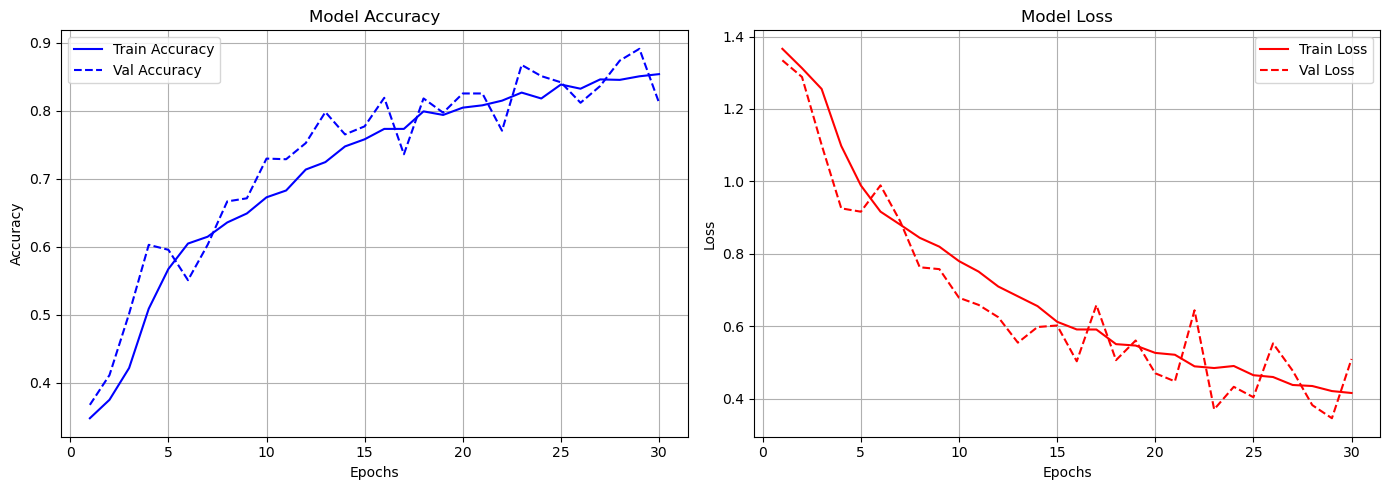

In [15]:
# Plot the training and validation accuracy and loss over epochs to evaluate model performance
epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(14, 5))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], 'b-', label='Train Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'b--', label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], 'r-', label='Train Loss')
plt.plot(epochs, history.history['val_loss'], 'r--', label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()